En general todos los imports se tienen instalados, el unico raro fue el de tensorflow

```
pip install tensorflow
```

Instala la version 2.8.0

In [71]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import imageio
import glob
import scipy.misc
import scipy.ndimage as ndimage
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf
import torch
import torch.backends.cudnn as cudnn
import argparse

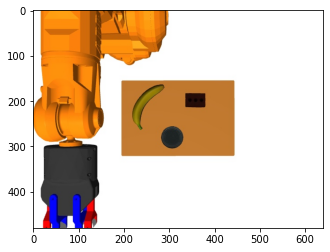

In [72]:
rgb_img = cv2.imread('/home/felipe/code/rgb.jpg', cv2.IMREAD_UNCHANGED)
rgb_img= cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

Para instalar la API object_detection

Clonar aparte

```
git clone https://github.com/tensorflow/models
```

Extraer directorio */research/object_detection* y copiarlo en el repo de grasping. Luego ejecutar:

```
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .
```

Ahi se instalan las dependencias que hagan falta, y los importrs de a continuación deberian servir.

Despues del proceso aparece una carpeta *object_detection.egg-info*



In [73]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

Para el modelo entrenado, esta em drive, como .zip. La forma más facil es instalar y luego descargar el modelo.

```
pip install gdown
gdown --id 1r2rrHPUWqJHr6X7f8PqBGA6k-Vx48Y25
```

El mode se de poner en la ruta models, junto con agnostic, yolo y la GGCNN.


In [74]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 2
pipeline_config = 'models/retina_config/config/pipeline.config'
checkpoint_path = "models/retina_config/checkpoint/ckpt-1"

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
     _prediction_heads=detection_model._box_predictor._prediction_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [75]:
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [76]:
resized = cv2.resize(rgb_img, (640,480), interpolation = cv2.INTER_AREA)

In [77]:
label_id_offset = 1
path="/content/resized.jpg"
#input_tensor = tf.convert_to_tensor(np.expand_dims(load_image_into_numpy_array(path), axis=0), dtype=tf.float32)
input_tensor = tf.convert_to_tensor(np.expand_dims(resized, axis=0), dtype=tf.float32)
detections = detect(input_tensor)

In [78]:
detections['detection_boxes'][0][0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.6013694 , 0.02283144, 1.        , 0.22955516], dtype=float32)>

In [79]:
shape=resized.shape
bin_img=resized[int(shape[0]*detections['detection_boxes'][0][0][0]):int(shape[0]*detections['detection_boxes'][0][0][2]),int(shape[1]*detections['detection_boxes'][0][0][1]):int(shape[1]*detections['detection_boxes'][0][0][3])]

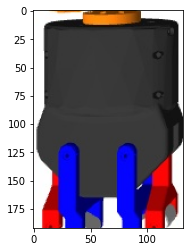

In [80]:
plt.imshow(bin_img)